<a href="https://colab.research.google.com/github/shauryaDugar/media-bias-detection/blob/main/Gender_Bias_Detector_using_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gender Bias Detection in Media Content by Fine Tuning Pre-Trained Transformers

---

This colab notebook contains code to fine tune 5 Pre-trained Transformer models on a gender bias sequence classification task. The dataset has been taken from mbib-full's dataset [gender-bias.csv](https://huggingface.co/datasets/mediabiasgroup/mbib-base/tree/main/mbib-aggregated)

The 5 Pre-trained Transformers used in this notebook are:


1.   XLNet
2.   ELECTRA
3.   RoBERTa
4.   BERT
5.   GPT-2

Just uncomment the model that you want to use in the cells below to be able to use it. Also, some models like the xlnet might be too big to fit in Google Colab/Kaggle's GPU RAM. Code to prevent RAM from getting exhausted will soon be updated.







Installing datasets Python package

In [1]:
!pip install datasets
!pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00


Importing all the required libraries

In [2]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from datasets import Dataset, load_dataset
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# importing a library that helps with knowing the amount of GPU memory that is occupied
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

print_gpu_utilization()

GPU memory occupied: 258 MB.


Upload the gender-bias.csv to session storage in colab and then run the next cell to load and preview the dataset.

In [4]:
gender_bias_ds = pd.read_csv('/content/gender-bias.csv')
gender_bias_ds = gender_bias_ds.convert_dtypes()
print("Original Dataset: \n")
print(gender_bias_ds.head(5))
print("\n\nSimplified Dataset: \n")
simple_ds = gender_bias_ds[['text', 'label']]
print(simple_ds.head(5))
train_df, test_df = train_test_split(simple_ds, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

Original Dataset: 

         id                                               text  label  \
0  075-2318  so what youre saying is blacks are more likely...      0   
1  075-2930  dont forget that they think blacks are too stu...      0   
2  107-3192  There is no way I d be eating that entree it s...      0   
3  075-2850  doctor stranges girlfriend is not a nurse shes...      1   
4  106-1124  It is not how much you are paid that matters B...      0   

   dataset_id  
0          75  
1          75  
2         107  
3          75  
4         106  


Simplified Dataset: 

                                                text  label
0  so what youre saying is blacks are more likely...      0
1  dont forget that they think blacks are too stu...      0
2  There is no way I d be eating that entree it s...      0
3  doctor stranges girlfriend is not a nurse shes...      1
4  It is not how much you are paid that matters B...      0


In [5]:
print_gpu_utilization()

GPU memory occupied: 258 MB.


A list of all tokenizers and models that can be used for sequence classification. Just uncomment the lines of the model that you want to use.

In [6]:
# xlnet_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
# xlnet_model = TFAutoModelForSequenceClassification.from_pretrained("xlnet-base-cased")

# electra_tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")
# electra_model = TFAutoModelForSequenceClassification.from_pretrained("bhadresh-savani/electra-base-emotion")

roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
roberta_model = TFAutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

# bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# bert_model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")

# gpt2_tokenizer = AutoTokenizer.from_pretrained("microsoft/DialogRPT-updown")
# gpt2_model = TFAutoModelForSequenceClassification.from_pretrained("microsoft/DialogRPT-updown", from_pt=True)


tokenizers_and_models = [('roberta', roberta_tokenizer, roberta_model)]
                        #  ('bert', bert_tokenizer, bert_model),
                        #  ('xlnet', xlnet_tokenizer, xlnet_model),
                        #  ('electra', electra_tokenizer, electra_model),
                        #  ('gpt2', gpt2_tokenizer, gpt2_model)]

model_metrics_df = pd.DataFrame(columns = ['name', 'accuracy', 'f1-score', 'precision', 'recall'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [7]:
print_gpu_utilization()

GPU memory occupied: 1398 MB.


Two helper functions that help in plotting training loss and accuracy graphs and confusion matrix and other metric calculations

In [8]:
def plot_training_curves(name, history):
  acc = history.history['accuracy']
  # val_acc = history.history['val_acc']
  loss = history.history['loss']
  # val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  # plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training accuracy - '+name)
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  # plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training loss - '+name)
  plt.legend()

  plt.show()

def plot_confusion_matrix_and_show_metrics(true_labels, pred_labels, name):
  metrics_to_return = [metrics.accuracy_score(true_labels, pred_labels),
                        metrics.f1_score(true_labels, pred_labels),
                        metrics.precision_score(true_labels, pred_labels),
                        metrics.recall_score(true_labels, pred_labels)]
  print(f"{name} accuracy: {metrics_to_return[0]}\n{name} f1-score: {metrics_to_return[1]}\n{name} precision: {metrics_to_return[2]}\n{name} recall: {metrics_to_return[3]}")
  cm = metrics.confusion_matrix(true_labels, pred_labels)
  # Define labels
  labels = ['0', '1']

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix - '+name)
  plt.show()
  return metrics_to_return


The code in the next cell contains a function that fine tunes a pretrained model on the gender-bias dataset, and shows the validation loss and accuracy along with confusion matrix and other metrics.

In [9]:
def train_and_evaluate(name, model, tokenizer):

  def tokenize_dataset(data):
      return tokenizer(data['text'])

  trainer_ds = train_ds.map(tokenize_dataset)
  tester_ds = test_ds.map(tokenize_dataset)

  tf_train_dataset = model.prepare_tf_dataset(trainer_ds, batch_size=32, shuffle=True, tokenizer=tokenizer)
  tf_test_dataset = model.prepare_tf_dataset(tester_ds, batch_size=32, shuffle=False, tokenizer=tokenizer)

  print(model.summary())
  model.compile(optimizer=tf.keras.optimizers.Adam(3e-5), metrics=['accuracy'])  # No loss argument!

  history = model.fit(tf_train_dataset, epochs=5)
  plot_training_curves(name, history)
  # model.evaluate(tf_test_dataset)
  logits = model.predict(tf_test_dataset).logits
  predicted_class_id = tf.math.argmax(logits, axis=-1)
  metrics = plot_confusion_matrix_and_show_metrics(test_df['label'], predicted_class_id.numpy(), name)
  model_metrics_df.loc[len(model_metrics_df.index)] = [name, metrics[0], metrics[1], metrics[2], metrics[3]]

The next cell contains the for loop which repeats the fine tuning for all models in the list

Map:   0%|          | 0/14352 [00:00<?, ? examples/s]

Map:   0%|          | 0/3588 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  593668    
 ificationHead)                                                  
                                                                 
Total params: 124648708 (475.50 MB)
Trainable params: 124648708 (475.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
448/448 [==============================] - 179s 279ms/step - loss: 0.4121 - accuracy: 0.8101
Epoch 2/5
448/448 [==============================] - 121s 270ms/step - loss: 0.2615 - accuracy: 0.8903
Epoch 3/5
448/448 [================

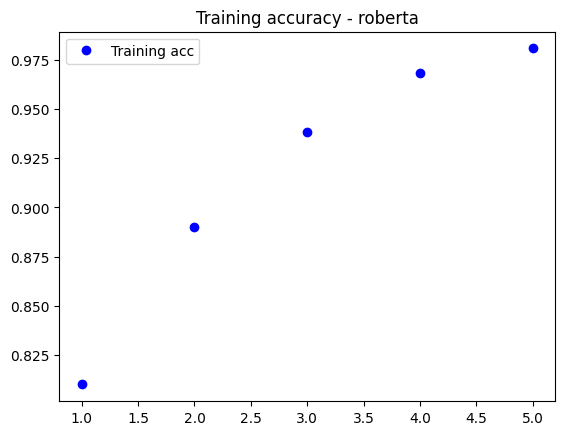

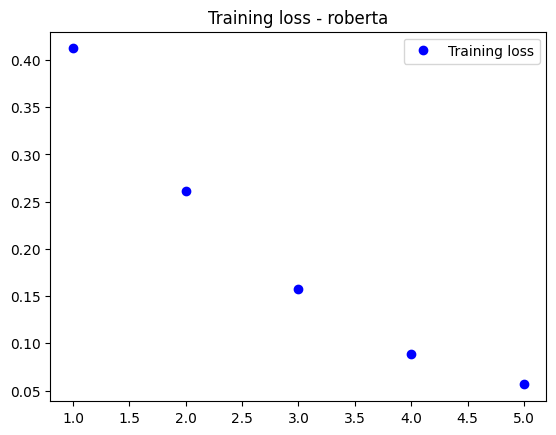

113/113 [==============================] - 14s 89ms/step
roberta accuracy: 0.8717948717948718
roberta f1-score: 0.8761443187937533
roberta precision: 0.8558653340347185
roberta recall: 0.897407611693326


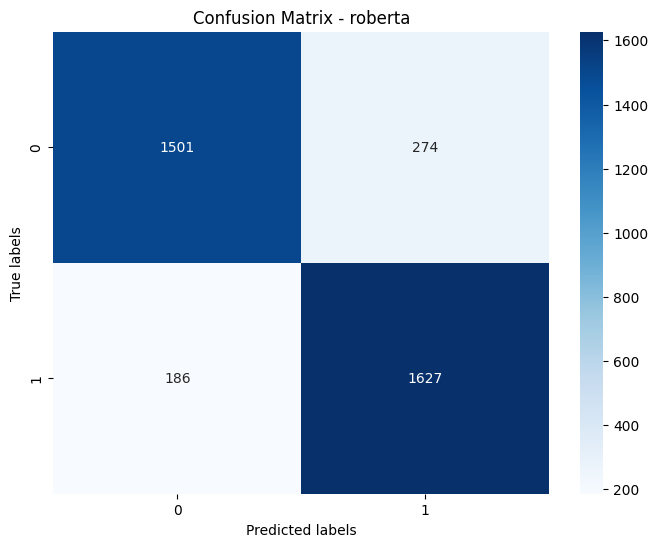

In [10]:
for (name, tokenizer, model) in tokenizers_and_models:
  train_and_evaluate(name, model, tokenizer)

In [11]:
print_gpu_utilization()

GPU memory occupied: 4570 MB.


In [12]:
print(model_metrics_df)

      name  accuracy  f1-score  precision    recall
0  roberta  0.871795  0.876144   0.855865  0.897408
